# Notebook 2.6.5: Epidemiology (Nondimensionalization)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
#@ Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap05.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap05 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap05.py


In the previous notebook we swept the parameters of the Kermack-McKendrick (KM) model: the contact rate, `beta`, and the recovery rate, `gamma`.
For each pair of parameters, we ran a simulation and computed the total fraction of the population infected.  In this notebook we'll investigate the relationship between the parameters and this metric, using both simulation and analysis.

The figures in the previous chapter suggest that there is a relationship between the parameters of the KM model, `beta` and `gamma`, and the fraction of the population that is infected. Let's think what that relationship might be.

<br>

-   When `beta` exceeds `gamma`, there are more contacts
    than recoveries during each day. The difference between `beta` and `gamma` might be called the *excess contact rate*, in units of contacts per day.

-   As an alternative, we might consider the ratio `beta/gamma`, which
    is the number of contacts per recovery. Because the numerator and
    denominator are in the same units, this ratio is *dimensionless*, which means it has no units.

<br>

Describing physical systems using dimensionless parameters is often a
useful move in the modeling and simulation game. In fact, it is so useful that it has a name: *nondimensionalization*.  So we'll try the second option first.

## Exploring the Results

In the previous chapter, we wrote a function, `sweep_parameters`,
that takes an array of values for `beta` and an array of values for `gamma`.
It runs a simulation for each pair of parameters and returns a `DataFrame` with the results.

I'll run it again with the following arrays of parameters.

In [ ]:
# Create a system
iS = 89; iI = 1; iR = 0    
tc = 3; tr = 4; t_end = 14*7

system = make_system(iS,iI,iR,tc,tr,t_end)

beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 
              0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]
frame = sweep_parameters(system, beta_array, gamma_array)

Here's what the first few rows look like:

In [ ]:
frame.head()

,0.2,0.4,0.6,0.8
0.1,0.010756,0.003642,0.002191,0.001567
0.2,0.118984,0.010763,0.005447,0.003644
0.3,0.589095,0.030185,0.010771,0.006526
0.4,0.801339,0.131563,0.020917,0.010780
0.5,0.896577,0.396409,0.046140,0.017640


The `DataFrame` has one row for each value of `beta` and one column for each value of `gamma`. 
We can print the values in the `DataFrame` like this:

In [ ]:
for gamma in frame.columns:
    column = frame[gamma]
    for beta in column.index:
        metric = column[beta]
        print(beta, gamma, metric)

0.1 0.2 0.010756340768063644
0.2 0.2 0.11898421353185373
0.3 0.2 0.5890954199973404
0.4 0.2 0.8013385277185551
0.5 0.2 0.8965769637207062
0.6 0.2 0.942929291399791
0.7 0.2 0.966299311298026
0.8 0.2 0.9781518959989762
0.9 0.2 0.9840568957948106
1.0 0.2 0.9868823507202488
1.1 0.2 0.988148177093735
0.1 0.4 0.0036416926514175607
0.2 0.4 0.010763463373360094
0.3 0.4 0.030184952469116566
0.4 0.4 0.131562924303259
0.5 0.4 0.3964094037932606
0.6 0.4 0.5979016626615987
0.7 0.4 0.7284704154876106
0.8 0.4 0.8144604459153759
0.9 0.4 0.8722697237137128
1.0 0.4 0.9116692168795855
1.1 0.4 0.9386802509510287
0.1 0.6 0.002190722188881611
0.2 0.6 0.005446688837466351
0.3 0.6 0.010771139974975585
0.4 0.6 0.020916599304195316
0.5 0.6 0.04614035896610047
0.6 0.6 0.13288938996079536
0.7 0.6 0.3118432512847451
0.8 0.6 0.47832565854255393
0.9 0.6 0.605687582114665
1.0 0.6 0.7014254793376209
1.1 0.6 0.7738176405451065
0.1 0.8 0.0015665254038139675
0.2 0.8 0.003643953969662994
0.3 0.8 0.006526163529085194
0.4 0

This is the first example we've seen with one `for` loop inside another:

-   Each time the outer loop runs, it selects a value of `gamma` from
    the columns of the `DataFrame` and extracts the corresponding
    column.

-   Each time the inner loop runs, it selects a value of `beta` from the index of the column and selects the corresponding element, which is the fraction of the population that got infected.

Since there are 11 rows and 4 columns, the total number of lines in the output is 44.

The following function uses the same loop to enumerate the elements of the `DataFrame`, but instead of printing a line for each column or row, it plots a point.

In [ ]:
from matplotlib.pyplot import plot

def plot_sweep_frame(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            plot(beta/gamma, metric, '.', color='C1')

On the $x$-axis, it plots the ratio `beta/gamma`.
On the $y$-axis, it plots the fraction of the population that's infected.

Here's what it looks like:

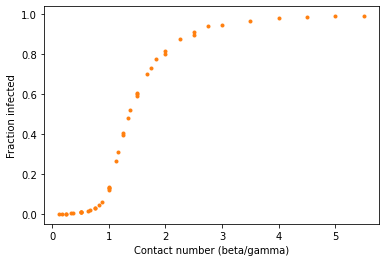

In [ ]:
plot_sweep_frame(frame)
axes = plt.gca()
axes.set(xlabel='Contact number (beta/gamma)',
         ylabel='Fraction infected');

The results fall on a single curve, at least approximately. That means that we can predict the fraction of the population that will be infected based on a single parameter, the ratio `beta/gamma`. We don't need to know the values of `beta` and `gamma` separately.

## Contact Number

From previous chapters, recall that the number of new infections in a
given day is $\beta s i N$, and the number of recoveries is
$\gamma i N$. If we divide these quantities, the result is
$\beta s / \gamma$, which is the number of new infections per recovery
(as a fraction of the population).

When a new disease is introduced to a susceptible population, $s$ is
approximately 1, so the number of people infected by each sick person is $\beta / \gamma$. This ratio is called the *contact number* or *basic reproduction number* (see <http://modsimpy.com/contact>). By convention it is usually denoted $R_0$, but in the context of an SIR model, that notation is confusing, so we'll use $c$ instead.

The results in the previous section suggest that there is a relationship between $c$ and the total number of infections. We can derive this relationship by analyzing the differential equations from
Chapter 11.  Remember that each of these differential equations is simply a rate equation: the first one, for instance, can be read, "the rate of change of susceptible students with respect to time is $-\beta si$":

$$\begin{aligned}
\frac{ds}{dt} &= -\beta s i \\
\frac{di}{dt} &= \beta s i - \gamma i\\
\frac{dr}{dt} &= \gamma i\end{aligned}$$ 

Why is the first equation always negative?  Why is the last one positive?  Is the middle one negative or positive?  When?

In the same way we divided the
contact rate by the infection rate to get the dimensionless quantity
$c$, now we'll divide $di/dt$ by $ds/dt$ to get a ratio of rates:

$$\frac{di}{ds} = \frac{\beta s i - \gamma i}{-\beta s i}$$ 

Which we can simplify as

$$\frac{di}{ds} = -1 + \frac{\gamma}{\beta s}$$ 

Replacing $\beta/\gamma$ with $c$, we can write

$$\frac{di}{ds} = -1 + \frac{1}{c s}$$ 

Dividing one differential equation by another is not an obvious move, but in this case it is useful because it gives us a relationship between $i$, $s$ and $c$ that does not depend on time. From that relationship, we can derive an equation that relates $c$ to the final value of $s$. In theory, this equation makes it possible to infer $c$ by observing the course of an epidemic.

Here's how the derivation goes.  Don't sweat this too much--just try to pick up the pattern of solving for a general solution using integration, then finding a particular solution. 

First we multiply both sides of the previous
equation by $ds$: 

$$di = \left( -1 + \frac{1}{cs} \right) ds$$ 

And then integrate both sides: 

$$i = -s + \frac{1}{c} \log s + q$$ 

where $q$ is a constant of integration. This is the general solution to our differential equation.

We want to define this constant of integration for our particular problem.  Rearranging terms yields:

$$q = i + s - \frac{1}{c} \log s$$ 

Now let's see if we can figure out what $q$ is. At the beginning of an epidemic, if the fraction infected is small and nearly everyone is susceptible, we can use the approximations $i(0) = 0$ (at time = 0, no one is infected) and $s(0) = 1$ (at time = 0, everyone is susceptible).  The equation must be true at time = 0, so we sub in i = 0 and s = 1 to find the $q$ value that will work:

$$q = 0 + 1 + \frac{1}{c} \log 1$$ 

Since $\log 1 = 0$, we get $q = 1$.

Now, we want to identify the constant $c$.  We can't use time = 0, because in that case the term with $c$ in it disappears.  So let's use the end of the epidemic.   At the end of the epidemic, let's assume that $i(\infty) = 0$, and $s(\infty)$ is an unknown quantity, $s_{\infty}$. Now we have:

$$q = 1 = 0 + s_{\infty}- \frac{1}{c} \log s_{\infty}$$ 

Solving for $c$, we get 

$$c = \frac{\log s_{\infty}}{s_{\infty}- 1}$$ 

By relating $c$ and $s_{\infty}$ (which is the total precentage who were not infected), this equation makes it possible to estimate $c$ based on data, and possibly predict the behavior of future epidemics.

## Analysis and Simulation

Let's compare this analytic result to the results from simulation. I'll create an array of values for $s_{\infty}$.

In [ ]:
s_inf_array = linspace(0.003, 0.99, 50)

And compute the corresponding values of $c$:

In [ ]:
from numpy import log

c_array = log(s_inf_array) / (s_inf_array - 1)

To get the total infected, we compute the difference between $s(0)$ and
$s(\infty)$, then store the results in a `Series`:

In [ ]:
frac_infected = 1 - s_inf_array

We'll put `c_array` (our index) and `frac_infected` (our data) in a Pandas `Series`.

In [ ]:
frac_infected_series = pd.Series(data=frac_infected,index=c_array)

Now we can plot the results:

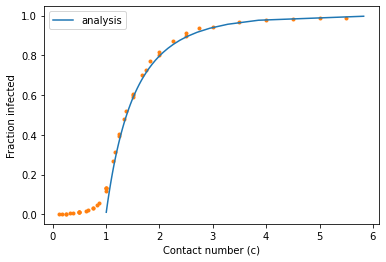

In [ ]:
plot_sweep_frame(frame)
frac_infected_series.plot(label='analysis',
                          xlabel='Contact number (c)',
                          ylabel='Fraction infected',
                         legend=True);

When the contact number exceeds 1, analysis and simulation agree. When
the contact number is less than 1, they do not: analysis indicates there should be no infections; in the simulations there are a small number of infections.

The reason for the discrepancy is that the simulation divides time into a discrete series of days, whereas the analysis treats time as a
continuous quantity.
When the contact number is large, these two models agree; when it is small, they diverge.

## Estimating Contact Number

The previous figure shows that if we know the contact number, we can estimate the fraction of the population that will be infected with just a few arithmetic operations.
We don't have to run a simulation.

We can also read the figure the other way; if we know what fraction of the population was affected by a past outbreak, we can estimate the contact number.
Then, if we know one of the parameters, like `gamma`, we can use the contact number to estimate the other parameter, like `beta`.

At least in theory, we can.
In practice, it might not work very well, because of the shape of the curve. 

* When the contact number is low, the curve is quite steep, which means that small changes in $c$ yield big changes in the number of infections. If we observe that the total fraction infected is anywhere from 20% to 80%, we would conclude that $c$ is near between 1 and 2.

* And when the contact number is high, the curve is nearly flat, which means that it's hard to see the difference between values of $c$ between 3 and 6.

With the uncertainty of real data, we might not be able to estimate $c$ with much precision.
But as one of the exercises below, you'll have a chance to try.

## Summary

In this chapter we used simulations to explore the relationship between `beta`, `gamma`, and the fraction infected.
Then we used analysis to explain that relationship.

With that, we are done with the Kermack-McKendrick model.

In [ ]:
# Useful functions
from matplotlib.pyplot import plot

def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system['t_end']]
    return s_0 - s_end


def sweep_beta(system,beta_array, gamma):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr, t_end= 1/system['beta'], 1/system['gamma'], system['t_end']

    for beta in beta_array:
        system_local = make_system(iS,iI,iR,1/beta,1/gamma,t_end)
        results = run_simulation(system_local, change_func)
        sweep[beta] = calc_total_infected(results, system_local)
    return sweep

def run_simulation(system, change_func):
    state = make_state(system)
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state
    
    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    
    return frame

def sweep_parameters(system,beta_array, gamma_array):
    frame = pd.DataFrame([],columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta(system,beta_array, gamma)
    return frame

def plot_sweep_frame(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            plot(beta/gamma, metric, '.', color='C1')

### Exercise 1

 At the beginning of this chapter, I suggested two ways to relate `beta` and `gamma`: we could compute their difference or their ratio.

Because the ratio is dimensionless, I suggested we explore it first, and that led us to discover the contact number, which is `beta/gamma`.
When we plotted the fraction infected as a function of the contact number, we found that this metric falls on a single curve, at least approximately.
That indicates that the ratio is enough to predict the results; we don't have to know `beta` and `gamma` individually. 

But that leaves a question open: what happens if we do the same thing using the difference instead of the ratio?

Write a version of `plot_sweep_frame`, called `plot_sweep_frame_difference`, that plots the fraction infected versus the difference `beta-gamma`.

What do the results look like, and what does that imply? 

In [ ]:
# Define plot_sweep_frame_difference
from matplotlib.pyplot import plot

def plot_sweep_frame_difference(frame):
    for gamma in frame.columns:
        column = frame[gamma]
        for beta in column.index:
            metric = column[beta]
            plot(beta-gamma, metric, '.', color='C1')

In [ ]:
# Simulate results
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 
              0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]
frame = sweep_parameters(system,beta_array, gamma_array)

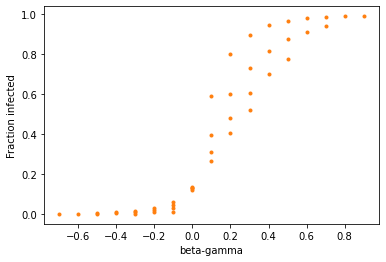

In [ ]:
# Plot results
plot_sweep_frame_difference(frame)
axes = plt.gca()
axes.set(xlabel='beta-gamma',
         ylabel='Fraction infected');


#### Explain your results here.  What is implied by these results?
The results here do not follow a single curve--the fraction infected does not rely only up on the difference between beta and gamma.  This is why nondimensionalization can be so powerful: it takes a complex set of inputs (here, beta and gamma) and reduces them to a single input (contact number c) that can explain the results by itself.  beta-gamma (which has units 'per day') is not as powerful--it cannot predict by itself the fraction infected.   

### Exercise 2

 Suppose you run a survey at the end of the semester and find that 26% of students had the Freshman Plague at some point.
What is your best estimate of `c`?

Hint: if you display `frac_infected_series`, you can read off the answer. 

#### Explain your answer here
If we look at the plot in the chapter notebook of "fraction infected vs. c", we can see that a fraction-infected rate of 26% corresponds to a contact number of $c \approx 1.1$.  

### Exercise 3

So far the only metric we have considered is the total fraction of the population that gets infected over the course of an epidemic.  That is an important metric, but it is not the only one we care about.

For example, if we have limited resources to deal with infected people, we might also be concerned about the number of people who are sick at the peak of the epidemic, which is the maximum of `I`.

Write a version of `sweep_beta` that computes this metric, and use it to compute a `DataFrame` for a range of values of `beta` and `gamma`.  Note that a Series has a `max` function, which finds the maximum value in the Series.  To implement it with a DataFrame, you can write it in the form `dataframename.columnname.max()`.

Make a contour plot that shows the value of this metric as a function of `beta` and `gamma`.

Then use `plot_sweep_frame` to plot the maximum of `I` as a function of the contact number, `beta/gamma`.
Do the results fall on a single curve?

In [ ]:
# Define sweep_beta_max, calc_max_infected, and sweep_parameters_max
def sweep_beta_max(system,beta_array, gamma):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS']*N, system['iI']*N,system['iR']*N
    tc, tr, t_end= 1/system['beta'], 1/system['gamma'], system['t_end']

    for beta in beta_array:
        system_local = make_system(iS,iI,iR,1/beta,1/gamma,t_end)
        results = run_simulation(system_local, change_func)
        sweep[beta] = calc_max_infected(results, system_local)
    return sweep

def calc_max_infected(results, system):
    max_inf = results.i.max()
    return max_inf

def sweep_parameters_max(beta_array, gamma_array):
    frame = pd.DataFrame([],columns=gamma_array)
    for gamma in gamma_array:
        frame[gamma] = sweep_beta_max(system,beta_array, gamma)
    return frame

def run_simulation(system, change_func):
    state = make_state(system)
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state
    
    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    
    return frame

In [ ]:
# Compute a SweepFrame using sweep_beta_max
beta_array = [0.1, 0.2, 0.3, 0.4, 0.5, 
              0.6, 0.7, 0.8, 0.9, 1.0 , 1.1]
gamma_array = [0.2, 0.4, 0.6, 0.8]

frame = sweep_parameters_max(beta_array, gamma_array)

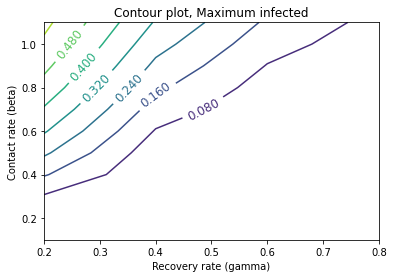

In [ ]:
# Create a contour plot for I with beta and gamma on the two axes
contour(frame)
ax = plt.gca()
ax.set(xlabel='Recovery rate (gamma)',
        ylabel='Contact rate (beta)',
        title='Contour plot, Maximum infected');

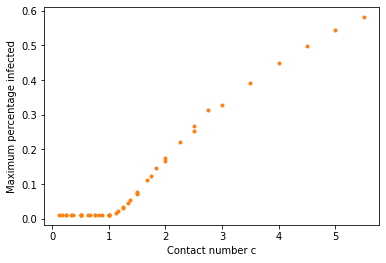

In [ ]:
# Use plot_sweep_frame to plot I as a function of c = beta/gamma
plot_sweep_frame(frame)

ax = plt.gca()
ax.set(xlabel='Contact number c',
         ylabel='Maximum percentage infected');

#### Explain your solution: what is the meaning of this plot?  Connect it to the COVID pandemic: how would this plot suggest the necessity for social distancing, especially early in the pandemic?

As the frequency of recovery decreases and the frequency of potentially infectious contact increases, the contact number c increases.   This higher contact number leads to a higher maximum percentage of infected persons.  In the COVID pandemic, it was important to reduce the demand on health care facilities by "flattening the curve": that is, but reducing the maximum number of infected people over the course of the pandemic.  Social distancing would decrease the frequency of potentially infectious contact, which would decrease c, which would decrease the maximum percentage infected.